# Entity Resolution Pipeline — Evaluation

Runs the entity resolution pipeline end-to-end and evaluates results:
- Baseline metrics (P/R/F1, confusion matrix, blocking recall)
- Error analysis (FP/FN details)
- Threshold sensitivity sweep
- Gray zone analysis
- Fuzzy SSN/birthdate experiments
- Golden record quality
- Summary and Phase 5 recommendations

## 1. Setup & Pipeline Execution

In [1]:
import sys
from pathlib import Path

# Setup paths
project_root = Path.cwd().parents[1]
er_dir = project_root / "entity-resolution"
sys.path.insert(0, str(er_dir))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.pipeline import (
    load_config,
    run_entity_resolution_pipeline,
    add_record_ids_to_ground_truth,
)
from src.data_loader import load_data_for_matching
from src.blocking import create_candidate_pairs, evaluate_blocking_recall
from src.comparison import build_comparison_features, add_composite_features
from src.classification import (
    classify_pairs,
    classify_tiered,
    label_features_with_ground_truth,
)
from src.evaluation import (
    evaluate_matches,
    error_analysis,
    evaluate_golden_records,
    generate_true_pairs_from_ground_truth,
    generate_confusion_matrix_report,
)
from src.golden_record import create_golden_records, build_match_clusters

plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline

print(f"Project root: {project_root}")
print(f"ER directory: {er_dir}")

Project root: /Users/alex/repos/Kaggle/SyntheticMass
ER directory: /Users/alex/repos/Kaggle/SyntheticMass/entity-resolution


In [2]:
# Load config and data
config = load_config(str(er_dir / "config" / "matching_config.yaml"))
patients_df, ground_truth_df = load_data_for_matching(config)

# Add record_ids to ground truth
ground_truth_df = add_record_ids_to_ground_truth(ground_truth_df, patients_df)

print(
    f"Patients: {len(patients_df)} records from {patients_df['facility_id'].nunique()} facilities"
)
print(
    f"Ground truth: {len(ground_truth_df)} entries, {ground_truth_df['true_patient_id'].nunique()} unique patients"
)
print(f"Columns: {list(ground_truth_df.columns)}")

Patients: 1228 records from 5 facilities
Ground truth: 1228 entries, 571 unique patients
Columns: ['true_patient_id', 'facility_id', 'num_encounters', 'errors_applied', 'first_name', 'last_name', 'maiden_name', 'ssn', 'birthdate', 'gender', 'address', 'city', 'zip', 'record_id']


In [3]:
# Step 2: Blocking
patients_indexed = patients_df.set_index("record_id")
strategy = config.get("blocking", {}).get("strategy", "aggressive_multipass")

candidate_pairs = create_candidate_pairs(patients_indexed, strategy=strategy)
print(f"\nCandidate pairs: {len(candidate_pairs):,}")

# Evaluate blocking recall
record_id_mapping = patients_df[["record_id", "facility_id", "id"]]
blocking_metrics = evaluate_blocking_recall(
    candidate_pairs, ground_truth_df, record_id_mapping
)
print(
    f"Blocking recall: {blocking_metrics['blocking_recall']:.2%} ({blocking_metrics['true_pairs_found']}/{blocking_metrics['true_pairs']})"
)


Candidate pairs: 18,481
Blocking recall: 100.00% (1121/1121)


In [4]:
# Step 3: Comparison
features = build_comparison_features(candidate_pairs, patients_indexed, config)
features = add_composite_features(features)
print(f"Features shape: {features.shape}")
print(f"Feature columns: {list(features.columns)}")
features.describe()

Features shape: (18481, 12)
Feature columns: ['first_name_sim', 'last_name_sim', 'address_sim', 'city_sim', 'state_match', 'zip_match', 'ssn_match', 'birthdate_match', 'total_score', 'name_score', 'address_score', 'high_confidence']


,first_name_sim,last_name_sim,address_sim,city_sim,state_match,zip_match,ssn_match,birthdate_match,total_score,name_score,address_score
count,18481.000000,18481.000000,18481.000000,18481.000000,18481.0,18481.000000,18481.000000,18481.000000,18481.000000,18481.000000,18481.000000
mean,0.491005,0.576721,0.522027,0.478704,1.0,0.175694,0.047184,0.041719,3.333053,0.533863,0.544106
std,0.287149,0.260149,0.127159,0.243041,0.0,0.380570,0.212037,0.199951,1.100044,0.188973,0.151029
min,0.000000,0.000000,0.297222,0.000000,1.0,0.000000,0.000000,0.000000,1.418223,0.000000,0.326041
25%,0.430556,0.455556,0.448465,0.417379,1.0,0.000000,0.000000,0.000000,2.794048,0.436772,0.471726
50%,0.500000,0.561905,0.500000,0.472222,1.0,0.000000,0.000000,0.000000,3.072100,0.530952,0.498286
75%,0.638889,0.730000,0.557937,0.555556,1.0,0.000000,0.000000,0.000000,3.408025,0.636508,0.534980
max,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000


In [5]:
# Step 4: Classification
matches = classify_pairs(features, config, ground_truth_df)
print(f"Predicted matches: {matches.sum()}")

# Step 5: Golden records
golden_records_df = create_golden_records(matches, patients_df, config)
print(f"Golden records: {len(golden_records_df)}")

# Step 6: Evaluation
eval_metrics = evaluate_matches(matches, ground_truth_df, patients_df)
golden_metrics = evaluate_golden_records(golden_records_df, ground_truth_df)
eval_metrics.update(golden_metrics)

print(generate_confusion_matrix_report(eval_metrics))

Predicted matches: 1131
Golden records: 563

Entity Resolution Evaluation Report

Confusion Matrix:
  True Positives:    1109
  False Positives:     22
  False Negatives:     12

Metrics:
  Precision: 0.9805
  Recall:    0.9893
  F1 Score:  0.9849

Pair Counts:
  Predicted pairs: 1131
  True pairs:      1121



## 2. Baseline Results

In [6]:
print("=== Baseline Pipeline Results ===")
print(f"  Blocking recall:   {blocking_metrics['blocking_recall']:.2%}")
print(f"  Candidate pairs:   {len(candidate_pairs):,}")
print(f"  Predicted matches: {matches.sum()}")
print(f"  True pairs:        {eval_metrics['true_pairs']}")
print(
    f"  TP: {eval_metrics['true_positives']}  FP: {eval_metrics['false_positives']}  FN: {eval_metrics['false_negatives']}"
)
print(f"  Precision: {eval_metrics['precision']:.4f}")
print(f"  Recall:    {eval_metrics['recall']:.4f}")
print(f"  F1 Score:  {eval_metrics['f1_score']:.4f}")
print(
    f"  Golden records: {eval_metrics['num_golden_records']} (expected: {eval_metrics['num_true_patients']})"
)

=== Baseline Pipeline Results ===
  Blocking recall:   100.00%
  Candidate pairs:   18,481
  Predicted matches: 1131
  True pairs:        1121
  TP: 1109  FP: 22  FN: 12
  Precision: 0.9805
  Recall:    0.9893
  F1 Score:  0.9849
  Golden records: 563 (expected: 571)


## 3. Error Analysis

In [7]:
error_results = error_analysis(matches, ground_truth_df, features, patients_df)
print(f"False positives: {error_results['fp_count']}")
print(f"False negatives: {error_results['fn_count']}")

# Show FP details
if len(error_results["false_positives"]) > 0:
    print("\n--- False Positives ---")
    fp_df = error_results["false_positives"]
    for _, row in fp_df.iterrows():
        r1, r2 = row["record_id_1"], row["record_id_2"]
        p1 = patients_df[patients_df["record_id"] == r1].iloc[0]
        p2 = patients_df[patients_df["record_id"] == r2].iloc[0]
        print(f"  {r1} vs {r2} (score={row['total_score']:.2f})")
        print(
            f"    {p1['first_name']} {p1['last_name']} | {p2['first_name']} {p2['last_name']}"
        )
        print(f"    SSN: {p1['ssn']} | {p2['ssn']}")
        print(f"    DOB: {p1['birthdate']} | {p2['birthdate']}")

# Show FN details
if len(error_results["false_negatives"]) > 0:
    print("\n--- False Negatives ---")
    fn_df = error_results["false_negatives"]
    for _, row in fn_df.iterrows():
        r1, r2 = row["record_id_1"], row["record_id_2"]
        p1 = patients_df[patients_df["record_id"] == r1].iloc[0]
        p2 = patients_df[patients_df["record_id"] == r2].iloc[0]
        print(f"  {r1} vs {r2} (score={row['total_score']:.2f})")
        print(
            f"    {p1['first_name']} {p1['last_name']} | {p2['first_name']} {p2['last_name']}"
        )
        print(f"    SSN: {p1['ssn']} | {p2['ssn']}")
        print(f"    DOB: {p1['birthdate']} | {p2['birthdate']}")

False positives: 22
False negatives: 12

--- False Positives ---
  facility_002_d9fb22dd-45ab-41e3-7c6c-393d74805e67 vs facility_003_696e60a8-c79c-a03c-f418-ec78ece84443 (score=5.63)
    Mari Rippin | Janelle Lindgren
    SSN: 999947134 | 799805391
    DOB: 1954-04-24 00:00:00 | 1954-04-24 00:00:00
  facility_003_5aa30275-c8b2-9bb2-bb15-f00c41cd7190 vs facility_005_674ded16-8fb0-be14-a197-c1cc2725f035 (score=6.00)
    Ming Grimes | Ping Little
    SSN: 999707542 | 999389919
    DOB: 1916-07-20 00:00:00 | 1916-07-20 00:00:00
  facility_001_3120693e-39a2-cf4d-04b4-bd642954ccfc vs facility_003_5aa30275-c8b2-9bb2-bb15-f00c41cd7190 (score=5.61)
    Celina Hackett | Ming Grimes
    SSN: 999332933 | 999707542
    DOB: 1916-07-20 00:00:00 | 1916-07-20 00:00:00
  facility_002_3120693e-39a2-cf4d-04b4-bd642954ccfc vs facility_003_5aa30275-c8b2-9bb2-bb15-f00c41cd7190 (score=5.69)
    Celina Lemke | Ming Grimes
    SSN: 999323933 | 999707542
    DOB: 1916-07-20 00:00:00 | 1916-07-20 00:00:00
  faci

## 4. Threshold Sensitivity

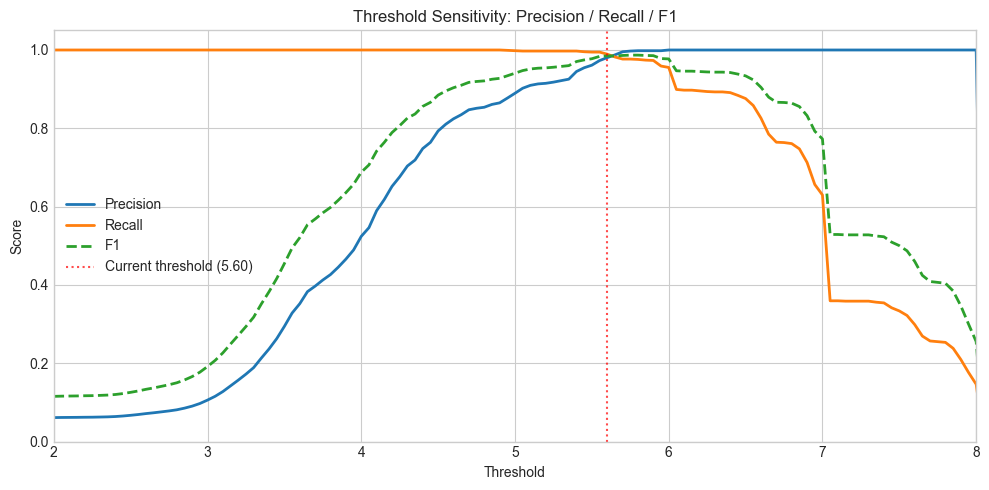


Best F1: 0.9869 at threshold 5.75 (P=0.9973, R=0.9768)


In [8]:
# Label features with ground truth
labeled = label_features_with_ground_truth(features, ground_truth_df)

# Sweep thresholds
thresholds = np.arange(2.0, 8.05, 0.05)
sweep_results = []

for t in thresholds:
    pred = labeled["total_score"] >= t
    tp = ((labeled["is_match"]) & pred).sum()
    fp = ((~labeled["is_match"]) & pred).sum()
    fn = ((labeled["is_match"]) & ~pred).sum()
    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
    sweep_results.append(
        {
            "threshold": t,
            "precision": p,
            "recall": r,
            "f1": f1,
            "tp": tp,
            "fp": fp,
            "fn": fn,
        }
    )

sweep_df = pd.DataFrame(sweep_results)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sweep_df["threshold"], sweep_df["precision"], label="Precision", linewidth=2)
ax.plot(sweep_df["threshold"], sweep_df["recall"], label="Recall", linewidth=2)
ax.plot(sweep_df["threshold"], sweep_df["f1"], label="F1", linewidth=2, linestyle="--")
ax.axvline(
    x=5.60, color="red", linestyle=":", alpha=0.7, label="Current threshold (5.60)"
)
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title("Threshold Sensitivity: Precision / Recall / F1")
ax.legend()
ax.set_xlim(2, 8)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Best F1
best = sweep_df.loc[sweep_df["f1"].idxmax()]
print(
    f"\nBest F1: {best['f1']:.4f} at threshold {best['threshold']:.2f} (P={best['precision']:.4f}, R={best['recall']:.4f})"
)

## 5. Gray Zone Analysis

Gray zone pairs (4.0-6.0): 1068
  True matches in gray zone: 50
  Non-matches in gray zone: 1018


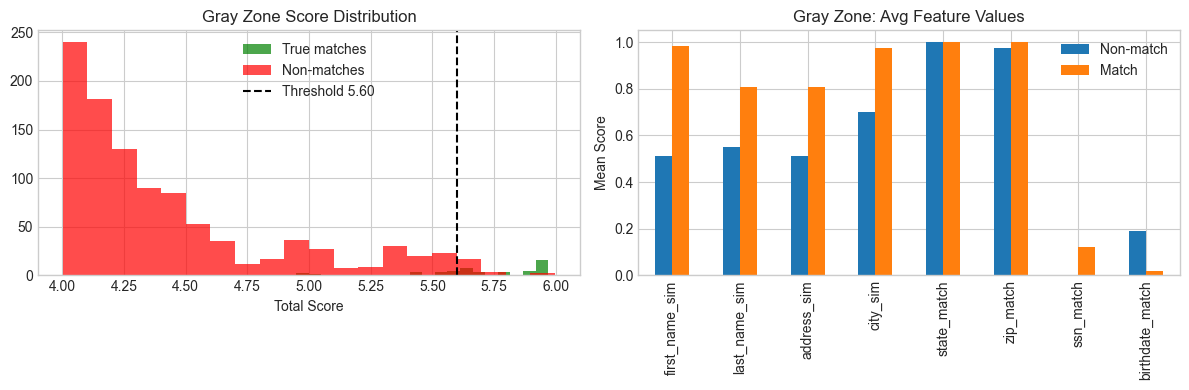

In [9]:
auto_reject = 4.0
auto_match = 6.0

gray_mask = (labeled["total_score"] >= auto_reject) & (
    labeled["total_score"] < auto_match
)
gray_zone = labeled[gray_mask].copy()

print(f"Gray zone pairs ({auto_reject}-{auto_match}): {len(gray_zone)}")
print(f"  True matches in gray zone: {gray_zone['is_match'].sum()}")
print(f"  Non-matches in gray zone: {(~gray_zone['is_match']).sum()}")

if len(gray_zone) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Score distribution by match status
    gray_matches = gray_zone[gray_zone["is_match"]]["total_score"]
    gray_non = gray_zone[~gray_zone["is_match"]]["total_score"]

    if len(gray_matches) > 0:
        axes[0].hist(
            gray_matches, bins=20, alpha=0.7, label="True matches", color="green"
        )
    if len(gray_non) > 0:
        axes[0].hist(gray_non, bins=20, alpha=0.7, label="Non-matches", color="red")
    axes[0].axvline(x=5.60, color="black", linestyle="--", label="Threshold 5.60")
    axes[0].set_title("Gray Zone Score Distribution")
    axes[0].set_xlabel("Total Score")
    axes[0].legend()

    # Feature breakdown for gray zone
    feature_cols = [
        "first_name_sim",
        "last_name_sim",
        "address_sim",
        "city_sim",
        "state_match",
        "zip_match",
        "ssn_match",
        "birthdate_match",
    ]
    cols_present = [c for c in feature_cols if c in gray_zone.columns]
    means = gray_zone.groupby("is_match")[cols_present].mean()
    means.T.plot(kind="bar", ax=axes[1])
    axes[1].set_title("Gray Zone: Avg Feature Values")
    axes[1].set_ylabel("Mean Score")
    axes[1].legend(["Non-match", "Match"])

    plt.tight_layout()
    plt.show()
else:
    print("No pairs in gray zone.")

## 6. Fuzzy SSN/Birthdate Experiment

Fuzzy features summary:
       first_name_sim  last_name_sim   address_sim      city_sim  state_match  \
count    18481.000000   18481.000000  18481.000000  18481.000000      18481.0   
mean         0.491005       0.576721      0.522027      0.478704          1.0   
std          0.287149       0.260149      0.127159      0.243041          0.0   
min          0.000000       0.000000      0.297222      0.000000          1.0   
25%          0.430556       0.455556      0.448465      0.417379          1.0   
50%          0.500000       0.561905      0.500000      0.472222          1.0   
75%          0.638889       0.730000      0.557937      0.555556          1.0   
max          1.000000       1.000000      1.000000      1.000000          1.0   

          zip_match     ssn_match  birthdate_match   total_score  \
count  18481.000000  18481.000000     18481.000000  18481.000000   
mean       0.175694      0.439755         0.042422      3.726328   
std        0.380570      0.159421         

/Users/alex/repos/Kaggle/SyntheticMass/.venv/lib/python3.12/site-packages/recordlinkage/compare.py:388: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  c[


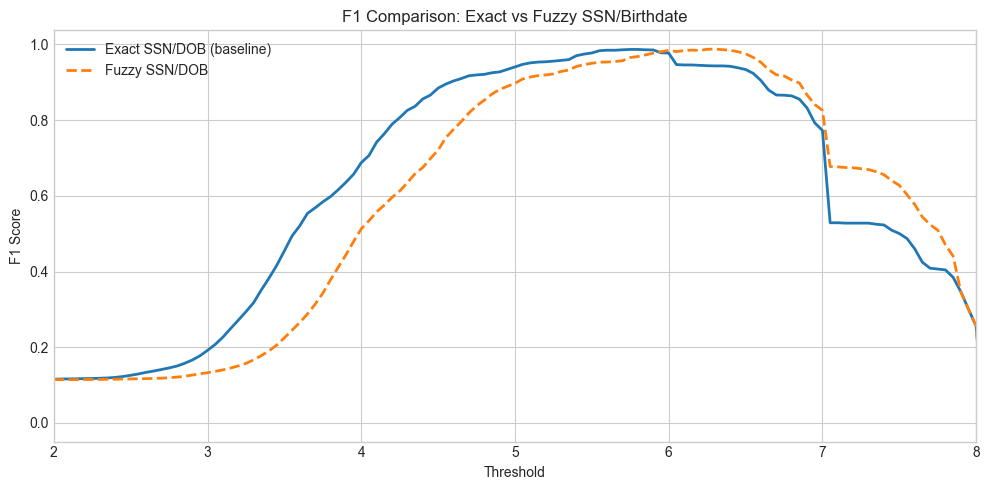


Best F1 (fuzzy): 0.9878 at threshold 6.30
Best F1 (exact): 0.9869 at threshold 5.75


In [10]:
# Re-run comparison with fuzzy SSN and birthdate
fuzzy_config = config.copy()
fuzzy_config["comparison"] = {"ssn_fuzzy": True, "birthdate_fuzzy": True}

fuzzy_features = build_comparison_features(
    candidate_pairs, patients_indexed, fuzzy_config
)
fuzzy_features = add_composite_features(fuzzy_features)

# Label with ground truth
fuzzy_labeled = label_features_with_ground_truth(fuzzy_features, ground_truth_df)

print("Fuzzy features summary:")
print(fuzzy_features.describe())

# Sweep thresholds for fuzzy config
fuzzy_sweep = []
for t in np.arange(2.0, 8.05, 0.05):
    pred = fuzzy_labeled["total_score"] >= t
    tp = ((fuzzy_labeled["is_match"]) & pred).sum()
    fp = ((~fuzzy_labeled["is_match"]) & pred).sum()
    fn = ((fuzzy_labeled["is_match"]) & ~pred).sum()
    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
    fuzzy_sweep.append({"threshold": t, "precision": p, "recall": r, "f1": f1})

fuzzy_sweep_df = pd.DataFrame(fuzzy_sweep)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    sweep_df["threshold"], sweep_df["f1"], label="Exact SSN/DOB (baseline)", linewidth=2
)
ax.plot(
    fuzzy_sweep_df["threshold"],
    fuzzy_sweep_df["f1"],
    label="Fuzzy SSN/DOB",
    linewidth=2,
    linestyle="--",
)
ax.set_xlabel("Threshold")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Comparison: Exact vs Fuzzy SSN/Birthdate")
ax.legend()
ax.set_xlim(2, 8)
plt.tight_layout()
plt.show()

fuzzy_best = fuzzy_sweep_df.loc[fuzzy_sweep_df["f1"].idxmax()]
print(
    f"\nBest F1 (fuzzy): {fuzzy_best['f1']:.4f} at threshold {fuzzy_best['threshold']:.2f}"
)
print(f"Best F1 (exact): {best['f1']:.4f} at threshold {best['threshold']:.2f}")

## 7. Golden Record Quality

In [11]:
from src.evaluation import calculate_cluster_purity

clusters = build_match_clusters(matches)
print(f"Total clusters: {len(clusters)}")
print(f"Expected unique patients: {ground_truth_df['true_patient_id'].nunique()}")

# Cluster size distribution
sizes = [len(c) for c in clusters]
size_counts = pd.Series(sizes).value_counts().sort_index()
print(f"\nCluster size distribution:")
for size, count in size_counts.items():
    print(f"  Size {size}: {count} clusters")

# Cluster purity
purity = calculate_cluster_purity(clusters, ground_truth_df)
print(f"\nAverage cluster purity: {purity:.4f}")

# Over/under-merge analysis
# Map each record to its true patient
record_to_true = dict(
    zip(ground_truth_df["record_id"], ground_truth_df["true_patient_id"])
)

over_merged = 0  # Clusters with records from multiple true patients
under_merged = 0  # True patients split across multiple clusters

true_patient_to_clusters = {}  # true_patient_id -> set of cluster indices
for i, cluster in enumerate(clusters):
    true_ids = set(record_to_true.get(rid) for rid in cluster if rid in record_to_true)
    true_ids.discard(None)
    if len(true_ids) > 1:
        over_merged += 1
    for tid in true_ids:
        true_patient_to_clusters.setdefault(tid, set()).add(i)

for tid, cluster_indices in true_patient_to_clusters.items():
    if len(cluster_indices) > 1:
        under_merged += 1

print(f"\nOver-merged clusters (multiple true patients): {over_merged}")
print(f"Under-merged patients (split across clusters): {under_merged}")

Total clusters: 346
Expected unique patients: 571

Cluster size distribution:
  Size 2: 170 clusters
  Size 3: 78 clusters
  Size 4: 61 clusters
  Size 5: 33 clusters
  Size 6: 3 clusters
  Size 10: 1 clusters

Average cluster purity: 0.9890

Over-merged clusters (multiple true patients): 9
Under-merged patients (split across clusters): 0


## 8. Summary & Recommendations

In [12]:
print("=" * 60)
print("ENTITY RESOLUTION PIPELINE — EVALUATION SUMMARY")
print("=" * 60)
print()
print("Baseline Configuration:")
print(f"  Blocking:        {strategy}")
print(f"  Features:        8 (exact SSN/DOB)")
print(f"  Classification:  tiered (auto_reject=4.0, auto_match=6.0, gray_zone=5.60)")
print()
print("Results:")
print(f"  Blocking recall: {blocking_metrics['blocking_recall']:.2%}")
print(f"  Candidate pairs: {len(candidate_pairs):,}")
print(f"  Precision:       {eval_metrics['precision']:.4f}")
print(f"  Recall:          {eval_metrics['recall']:.4f}")
print(f"  F1 Score:        {eval_metrics['f1_score']:.4f}")
print(
    f"  Golden records:  {eval_metrics['num_golden_records']} (expected {eval_metrics['num_true_patients']})"
)
print(f"  Cluster purity:  {purity:.4f}")
print()
print("Comparison Table:")
print(f"  {'Config':<25} {'Best F1':<10} {'Threshold':<12}")
print(f"  {'Exact SSN/DOB':<25} {best['f1']:<10.4f} {best['threshold']:<12.2f}")
print(
    f"  {'Fuzzy SSN/DOB':<25} {fuzzy_best['f1']:<10.4f} {fuzzy_best['threshold']:<12.2f}"
)
print()
print("Phase 5 Recommendations:")
print("  - Use LLM (MedGemma) for gray zone pairs to improve F1")
print("  - Focus on pairs scoring 4.0-6.0 where demographic signals are ambiguous")
print("  - Medical history comparison can resolve cases where names/addresses differ")
print(
    "  - Estimate: ~{} pairs for LLM review".format(
        len(gray_zone) if len(gray_zone) > 0 else "N/A"
    )
)
print("=" * 60)

ENTITY RESOLUTION PIPELINE — EVALUATION SUMMARY

Baseline Configuration:
  Blocking:        aggressive_multipass
  Features:        8 (exact SSN/DOB)
  Classification:  tiered (auto_reject=4.0, auto_match=6.0, gray_zone=5.60)

Results:
  Blocking recall: 100.00%
  Candidate pairs: 18,481
  Precision:       0.9805
  Recall:          0.9893
  F1 Score:        0.9849
  Golden records:  563 (expected 571)
  Cluster purity:  0.9890

Comparison Table:
  Config                    Best F1    Threshold   
  Exact SSN/DOB             0.9869     5.75        
  Fuzzy SSN/DOB             0.9878     6.30        

Phase 5 Recommendations:
  - Use LLM (MedGemma) for gray zone pairs to improve F1
  - Focus on pairs scoring 4.0-6.0 where demographic signals are ambiguous
  - Medical history comparison can resolve cases where names/addresses differ
  - Estimate: ~1068 pairs for LLM review
